In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv


In [58]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt



In [59]:
df=pd.read_csv('/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv',sep='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [60]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [61]:

def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [62]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [63]:
def cleaning(df, stop_words):

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split()))


    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')

    # Removing stop words

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)

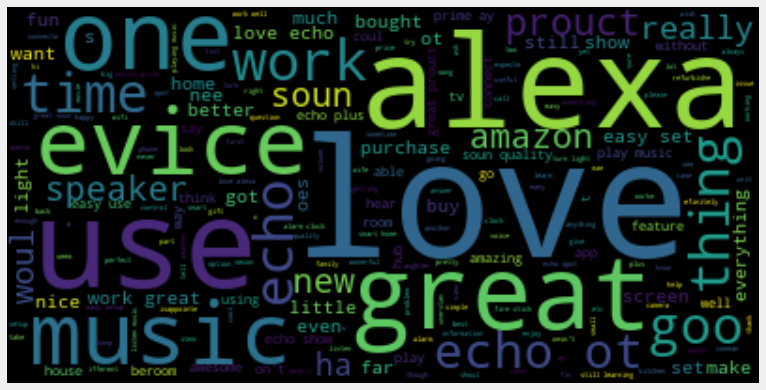

In [64]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

In [66]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)

In [67]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 319, 120)          60000     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 319, 120)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 176)               209088    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 354       
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [69]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [70]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 3s 91ms/step - loss: 0.2608 - accuracy: 0.8931


[0.26079270243644714, 0.8931217193603516]